# Part 0: Preparation

In [1]:
# Import libraries needed for this project
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Import dataset
df = pd.read_excel("../../Downloads/online.xlsx")

# Inspect random 5 rows
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
523054,580501,23307,SET OF 60 PANTRY DESIGN CAKE CASES,1,2011-12-04 13:00:00,0.55,14546.0,United Kingdom
176316,551997,21090,SET/6 COLLAGE PAPER PLATES,3,2011-05-05 15:47:00,0.83,NaN,United Kingdom
463364,576062,22099,CARAVAN SQUARE TISSUE BOX,1,2011-11-13 15:30:00,0.39,12867.0,United Kingdom
177134,552042,37448,CERAMIC CAKE DESIGN SPOTTED MUG,12,2011-05-06 09:00:00,1.49,13952.0,United Kingdom
452231,575329,23360,SET 8 CANDLES VINTAGE DOILY,4,2011-11-09 13:50:00,1.95,17038.0,United Kingdom


In [3]:
# Print out the general info of the dataset: shape, dtypes, null-values, memory usage, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The original dataframe has 541909 entries and 8 columns.

### Remove entries with null values

In [4]:
# Print out the summary of null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# check if rows that don't have `Descriptions` don't have `CustomerID` either
if df[(df['Description'].isna()) & (df['CustomerID'].isna())].shape[0] == 1454:
    print("Entries that don't have `Descriptions` don't have `CustomerID` either")

Entries that don't have `Descriptions` don't have `CustomerID` either


About 25% of the entries are not assigned to a particular customer. It is impossible to impute values for the user and these entries are thus useless. So I delete them from the dataframe.

In [6]:
# Delete rows that don't have `CustomerID`
df.dropna(axis=0, subset=['CustomerID'], inplace=True)

# Print the dimensions after dropping rows
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (406829, 8)


### Remove duplicated entries

In [7]:
# Print duplicated entries
print('Duplicated entries: {}'.format(df.duplicated().sum()))

# Drop duplicated entries
df.drop_duplicates(inplace = True)

Duplicated entries: 5225


In [8]:
# Print the dimensions after dropping rows
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (401604, 8)


### Deal with canceled orders

In [9]:
# Count canceled orders
df['canceled'] = df['InvoiceNo'].astype(str).apply(lambda x: int(x[0]=='C'))

canceled = df['canceled']
num_canceled = sum(canceled) 
num_total_orders = len(canceled)

print('Number of orders canceled: {}/{} ({:.2f}%) '.format(num_canceled, num_total_orders, num_canceled/num_total_orders*100))

Number of orders canceled: 8872/401604 (2.21%) 


In [10]:
# Check if all canceled values have negative `Quantity` and if all entries with negative `Quantity` are canceled orders
if df[(df['Quantity'] == 0)].shape[0] != 0:
    print("There are entries that have `Quantity` as 0.")

if df[(df['Quantity'] < 0) & (df['canceled']==0)].shape[0]: 
    print("There are entities that are not canceled but have negative `Quantity`.")

if df[(df['Quantity'] > 0) & (df['canceled']==1)].shape[0]:
    print("There are canceled orders that have positive `Quantity`.")

In [11]:
display(df.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,canceled
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,1
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland,0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland,0
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,0


From the first two rows I suspect that all the cancled values are returned items that have exact counterparts. So I check if there is violation to the hypothesis.

In [12]:
canceled_orders = df[df['Quantity'] < 0]
for index, col in canceled_orders.iterrows():
    if df[(df['InvoiceDate'] < col['InvoiceDate']) & (df['CustomerID'] == col['CustomerID']) & (df['Quantity'] == -col['Quantity']) & (df['Description'] == col['Description'])].shape[0] == 0: 
        print(df.loc[index])
        print(15*'='+'HYPOTHESIS NOT FULFILLED'+15*'=')
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                   14527
Country             United Kingdom
canceled                         1
Name: 141, dtype: object
===============HYPOTHESIS NOT FULFILLED===============


It turns out the canceled order can also means "Discount". So I run another test to see canceled orders other than "Discount" are all returned orders that have matching amount and quantity.

In [15]:
canceled_orders_not_discounts = df[(df['Quantity'] < 0) & (df['StockCode'] != 'D')]
for index, col in canceled_orders_not_discounts.iterrows():
    if df[(df['InvoiceDate'] < col['InvoiceDate']) & (df['CustomerID'] == col['CustomerID']) & (df['Quantity'] == -col['Quantity']) & (df['Description'] == col['Description'])].shape[0] == 0:  
        print(df.loc[index])
        print(15*'='+'HYPOTHESIS NOT FULFILLED'+15*'=')
        break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
canceled                                     1
Name: 154, dtype: object
===============HYPOTHESIS NOT FULFILLED===============


Cancellations do not necessarily have a counterpart beforehand.

In [16]:
with_counterpart_entry = []
without_counterpart_entry = 0

for _, col in canceled_orders.iterrows():
    counterpart = df[(df['InvoiceDate'] < col['InvoiceDate']) & (df['CustomerID'] == col['CustomerID']) & (df['Quantity'] == -col['Quantity']) & (df['Description'] == col['Description'])]
    
    # Cancelation WITHOUT counterpart
    if (counterpart.shape[0] == 0): 
        without_counterpart_entry += 1
    
    # Cancelation WITH a counterpart
    elif (counterpart.shape[0] == 1): 
        counterpart_index = counterpart.index[0]
        with_counterpart_entry.append(counterpart_index)        

In [17]:
print("canceled entries with counterparts: {}".format(len(with_counterpart_entry)))
print("canceled entries without counterparts: {}".format(without_counterpart_entry))

canceled entries with counterparts: 2260
canceled entries without counterparts: 5983


In [18]:
# Drop entries that have counterparts
df.drop(with_counterpart_entry, axis=0, inplace=True)

In [19]:
# Only keep entries that have positive `Quantity` for future analysis
df = df[df['Quantity'] > 0]

In [20]:
# Drop unnecessary column
df.drop(['canceled'], axis=1, inplace=True)

### Stock code analysis

In [21]:
special_stockcodes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]['StockCode'].unique()
special_stockcodes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [22]:
# Print out the description of these special stockcodes
for code in special_stockcodes:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


# Part I: Cohort Analysis and visualization

### Preparation

In [23]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [24]:
# Assign the acquisition month cohort to each customer
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01


In [25]:
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
410713,572127,22951,60 CAKE CASES DOLLY GIRL DESIGN,24,2011-10-21 09:20:00,0.55,14911.0,EIRE,2011-10-01,2010-12-01
156047,550057,22460,EMBOSSED GLASS TEALIGHT HOLDER,4,2011-04-14 12:01:00,1.25,14606.0,United Kingdom,2011-04-01,2010-12-01
404414,571676,23331,DECORATIVE WICKER HEART SMALL,2,2011-10-18 13:29:00,0.63,16910.0,United Kingdom,2011-10-01,2011-09-01
381754,569893,23419,HOME SWEET HOME BOTTLE,12,2011-10-06 15:51:00,2.08,12627.0,Germany,2011-10-01,2011-07-01
489393,578013,21584,RETROSPOT SMALL TUBE MATCHES,2,2011-11-22 12:55:00,1.65,17360.0,United Kingdom,2011-11-01,2011-06-01


In [26]:
# Define function to extract year, month, and day integer values
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [27]:
# Assign time offset value
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
78931,542905,21914,BLUE HARMONICA IN BOX,12,2011-02-01 15:11:00,1.25,12540.0,Spain,2011-02-01,2010-12-01,3
464944,576190,21733,RED HANGING HEART T-LIGHT HOLDER,2,2011-11-14 11:46:00,2.95,15039.0,United Kingdom,2011-11-01,2010-12-01,12
218359,556041,22084,PAPER CHAIN KIT EMPIRE,3,2011-06-08 12:44:00,2.95,17954.0,United Kingdom,2011-06-01,2010-12-01,7
420198,572880,22632,HAND WARMER RED RETROSPOT,1,2011-10-26 13:35:00,2.10,16415.0,United Kingdom,2011-10-01,2011-10-01,1
173926,551727,21932,SCANDINAVIAN PAISLEY PICNIC BAG,5,2011-05-04 08:40:00,2.95,14245.0,United Kingdom,2011-05-01,2011-03-01,3


In [28]:
# Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   884.0  324.0  286.0  338.0  319.0  352.0  319.0  308.0  313.0   
2011-01-01   415.0   90.0  111.0   95.0  134.0  120.0  103.0  101.0  125.0   
2011-02-01   381.0   71.0   71.0  107.0  103.0   94.0   96.0  106.0   94.0   
2011-03-01   451.0   66.0  112.0   89.0  101.0   76.0  121.0  104.0  126.0   
2011-04-01   300.0   64.0   61.0   63.0   59.0   69.0   65.0   78.0   22.0   
2011-05-01   283.0   55.0   49.0   49.0   59.0   65.0   75.0   26.0    NaN   
2011-06-01   242.0   42.0   38.0   64.0   56.0   81.0   23.0    NaN    NaN   
2011-07-01   187.0   34.0   39.0   42.0   51.0   21.0    NaN    NaN    NaN   
2011-08-01   169.0   35.0   41.0   41.0   21.0    NaN    NaN    NaN    NaN   
2011-09-01   296.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   357.0   86.0   41.0    NaN    NaN    NaN    NaN    

### Calculate retention rate

In [29]:
# Store the first column as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [30]:
# Review the retention table
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.7,32.4,38.2,36.1,39.8,36.1,34.8,35.4,39.5,37.4,50.2,26.5
2011-01-01,100.0,21.7,26.7,22.9,32.3,28.9,24.8,24.3,30.1,32.8,36.6,11.8,NaN
2011-02-01,100.0,18.6,18.6,28.1,27.0,24.7,25.2,27.8,24.7,30.4,6.8,NaN,NaN
2011-03-01,100.0,14.6,24.8,19.7,22.4,16.9,26.8,23.1,27.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,23.0,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.4,17.3,17.3,20.8,23.0,26.5,9.2,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.2,20.9,22.5,27.3,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.3,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Other metrics(Quantity)
# grouping = online.groupby(['CohortMonth', 'CohortIndex'])
# cohort_data = grouping['Quantity'].mean()
# cohort_data = cohort_data.reset_index()
# average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')

### Visualize Cohort Analysis

In [32]:
# Check the pivot table's index type
type(retention.index)

pandas.core.indexes.datetimes.DatetimeIndex

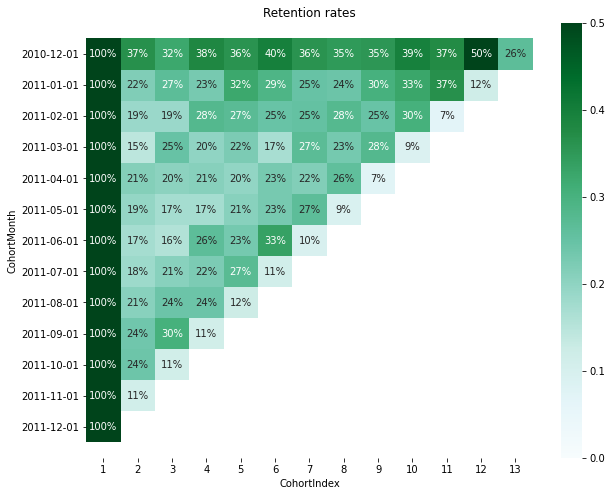

In [33]:
# Create an empty figure with pre-defined width and height in inches
plt.figure(figsize=(10,8))

# Add a title to the table
plt.title('Retention rates')

# Create the heatmap
ax = sns.heatmap(data=retention,
            annot=True,         # Display the numbers
            fmt='.0%',          # Format as pencentage with one decimal value
            vmin=0.0,
            vmax=0.5,           # Anchor the heatmap and make sure the outliers don't impact the visualization
            cmap='BuGn')        # Color palette        

# Set the y-axis names as an array of formatted strings specified by the format
ax.set_yticklabels(retention.index.strftime('%Y-%m-%d'))

# Fix a visualization bug in heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Show the plot
plt.show()

# Part II: Recency, frequency, monetary(RFM) segmentation

In [35]:
# Format the InvoiceDate for easier interpretation
def get_day(x): return dt.datetime(x.year, x.month, x.day)
df['InvoiceDate'] = df['InvoiceDate'].apply(get_day)

In [36]:
# Online table only has data from past 12 months
print('Min:{}; Max:{}'.format(min(df.InvoiceDate), max(df.InvoiceDate)))

Min:2010-12-01 00:00:00; Max:2011-12-09 00:00:00


In [37]:
# Data preparation
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [38]:
# Create a hypothetical snapshot_day data as if we're doing analysis recently
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)

In [39]:
# Aggregate data on a customer level
datamart = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns for easier interpretation
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Check a few rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,37,79,2405.51


In [40]:
datamart.describe()

,Recency,Frequency,MonetaryValue
count,4328.000000,4328.000000,4328.000000
mean,93.112523,90.227819,1969.995634
std,100.158163,224.661767,8464.223785
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,303.930000
50%,51.000000,41.000000,659.435000
75%,142.250000,98.000000,1646.075000
max,374.000000,7650.000000,280206.020000


In [41]:
# Inspect the cases when MonetaryValue is 0
datamart[datamart['MonetaryValue']==0]

,Recency,Frequency,MonetaryValue
CustomerID,,,
13256.0,15,1,0.0


In [42]:
df[df['CustomerID']==13256]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25,0.0,13256.0,United Kingdom,2011-11-01,2011-11-01,1,0.0


It turns out the `UnitPrice` is 0, that's why `TotalSum` is 0. For the future log transformation I drop this row.

In [43]:
datamart = datamart.drop(13256)
df = df.drop(502122)

### Building RFM segments

In [44]:
# Recency quartile
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels=r_labels)
datamart = datamart.assign(R=r_quartiles)

# Frequency quartile
f_labels = range(1, 5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels=f_labels)
datamart = datamart.assign(F=f_quartiles)

# Monetary quartile
m_labels = range(1, 5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels=m_labels)
datamart = datamart.assign(M=m_quartiles)

In [45]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12347.0,3,182,4310.00,4,4,4
12348.0,76,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,311,17,334.40,1,1,2
12352.0,37,79,2405.51,3,3,4


In [46]:
# Concatenate RFM quartile values to RFM_Segment
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

# Sum RFM quartiles values to RFM_Score
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1)

In [47]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,3,182,4310.00,4,4,4,444,12.0
12348.0,76,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,311,17,334.40,1,1,2,112,4.0
12352.0,37,79,2405.51,3,3,4,334,10.0


In [48]:
# Largest RFM segments
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    441
111    390
344    220
122    200
211    179
233    169
333    167
222    163
433    143
322    127
dtype: int64

In [49]:
# Bottom 5 '111' RFM Segments
datamart[datamart['RFM_Segment'] == '111'].tail(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
18224.0,264,10,158.95,1,1,1,111,3.0
18227.0,218,5,93.75,1,1,1,111,3.0
18269.0,367,6,138.90,1,1,1,111,3.0
18280.0,278,10,180.60,1,1,1,111,3.0
18281.0,181,7,80.82,1,1,1,111,3.0


### Find average value for RFM score segment

In [50]:
# Summary metrics per RFM score
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         262.1       8.2         156.7   390
4.0         174.7      13.7         239.5   385
5.0         152.9      21.0         360.4   512
6.0          96.8      27.6         611.8   460
7.0          80.5      38.6         746.6   452
8.0          63.9      55.7         980.9   462
9.0          46.4      78.9        1380.0   410
10.0         33.2     110.7        2062.5   422
11.0         21.4     184.7        4004.4   393
12.0          7.6     371.3        9311.4   441

In [51]:
# Group customers to Gold, Silver, Bronze segments
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif df['RFM_Score'] >= 5 and df['RFM_Score'] < 9:
        return 'Silver'
    else:
        return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            218.7      10.9         197.8   775
Gold               26.9     189.3        4271.5  1666
Silver            100.1      35.3         666.3  1886

# Part III: Data pre-processing for clustering
### Assumptions of k-means 
1. Symmetrical distribution of variables
2. Equal average values of variables
3. Equal standard deviation of variables

### Visualize RFM distribution

In [53]:
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]

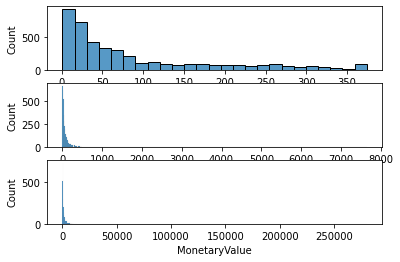

In [63]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.histplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.histplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.histplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

### Pre-process RFM data

In [60]:
# Unskew the data
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

### Visualize the normalized variables

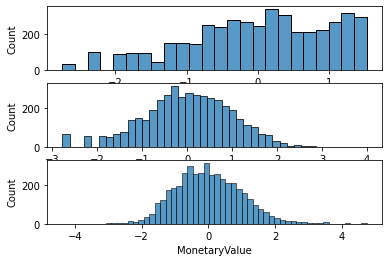

In [62]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.histplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.histplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.histplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

# Part IV: Implementation of k-means clustering
### Choosing the number of clusters - Elbow criterion method

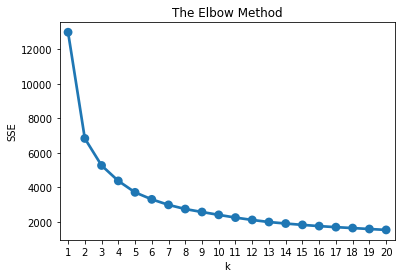

In [64]:
# Fit KMeans and calculate SSE for each `k`
sse = {}

# Fit KMeans and calculate SSE for each `k` between 1 and 20
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Run k-means(k=2)

In [65]:
# Initialize KMeans
kmeans = KMeans(n_clusters=2, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

### Assign labels to raw data

In [66]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k2 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k2.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         142.7      24.5         449.1  2396
1          31.6     171.8        3858.2  1931

### Run k-means(k=3)

In [67]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          69.6      62.1        1050.6  1868
1         176.9      14.5         288.0  1461
2          14.7     253.9        6155.1   998

### Prepare data for the snake plot

In [68]:
datamart_normalized = datamart_normalized.assign(Cluster=cluster_labels)

In [69]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

### Visualize a snake plot

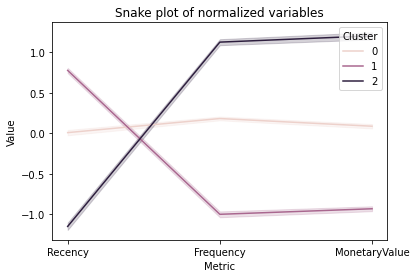

In [70]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

### Relative importance of each attribute

In [71]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.25      -0.31          -0.47
1           0.90      -0.84          -0.85
2          -0.84       1.81           2.12


As a ratio moves away from 0, attribute importance for a segment increases

### Plot relative importance heatmap

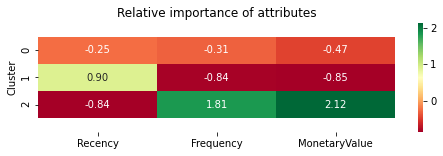

In [72]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8,2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
ax = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')

# Fix a visualization bug in heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()